# Deepwalk-SSP

Deepwalk-SSP is a Python repository that implements student representation learning using DeepWalk, a network representation learning technique.

## M. Amintoosi

In [4]:
import scipy.io
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def create_graph_from_bow(student_course_matrix):  
    """  
    Creates a NetworkX graph from a bag-of-words (BoW) representation.  

    Args:  
        student_course_matrix: A NumPy array representing the BoW representation. Each row corresponds to a node (e.g., student),   
           and each column corresponds to a feature (e.g., course).  A non-zero value indicates the presence of the feature.  

    Returns:  
        A NetworkX graph where nodes represent samples from student_course_matrix, and edges represent common features with weights based on the number of common features.  Returns None if input is invalid.  
    """  
    if not isinstance(student_course_matrix, np.ndarray):  
        print("Error: Input student_course_matrix must be a NumPy array.")  
        return None  
    if student_course_matrix.ndim != 2:  
        print("Error: Input student_course_matrix must be a 2D NumPy array.")  
        return None  

    G = nx.Graph()  

    num_nodes = student_course_matrix.shape[0]  
    for i in range(num_nodes):  
        G.add_node(i)  

    for i in range(num_nodes):  
        for j in range(i + 1, num_nodes):  
            common_courses = np.sum(student_course_matrix[i] * student_course_matrix[j])  
            if common_courses > 0:  
                G.add_edge(i, j, weight=common_courses)  
    return G  

# Example Usage:  
# Assuming 'student_course_matrix' is your NumPy array representing the BoW  
#G = create_graph_from_bow(student_course_matrix)  

#if G:  
#    print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

In [6]:
import networkx as nx  
from tqdm import tqdm  

def generate_random_walks(G, num_walks_per_node=80, walk_length=10):  
    """  
    Generates random walks from a given graph.  

    Args:  
        G: A NetworkX graph.  
        num_walks_per_node: The number of random walks to generate per node.  
        walk_length: The length of each random walk.  

    Returns:  
        A list of random walks (each walk is a list of node IDs).  Returns an empty list if the input graph is invalid.  

    """  
    if not isinstance(G, nx.Graph):  
        print("Error: Input must be a NetworkX graph.")  
        return []  

    walks = []  
    def random_walk(start_node, walk_length):  
        walk = [start_node]  
        current_node = start_node  
        for _ in range(walk_length -1):  # -1 because we already added the start node  
            neighbors = list(G.neighbors(current_node))  
            if neighbors:  
                next_node = np.random.choice(neighbors)  
                walk.append(next_node)  
                current_node = next_node  
            else: #Handle isolated nodes  
                break #or append current node again, depending on your needs  
        return walk  

    import numpy as np  
    for node in tqdm(G.nodes, desc="Nodes"):  
        for _ in range(num_walks_per_node):  
            walks.append(random_walk(node, walk_length))  
    return walks  

# Example usage (assuming 'G' is your NetworkX graph):  
#walks = generate_random_walks(G)  

#print(f"Generated {len(walks)} random walks.")

In [7]:
from gensim.models import Word2Vec  
import numpy as np  

def train_word2vec(walks, vector_size=5, window=5, hs=1, sg=1, workers=2, seed=1, epochs=30):  
    """  
    Trains a Word2Vec model on a list of random walks.  

    Args:  
        walks: A list of random walks (each walk is a list of node IDs).  
        vector_size: Dimensionality of the word embeddings.  
        window: Context window size.  
        hs: If 1, hierarchical softmax will be used for model training.  
        sg: If 1, skip-gram architecture will be used (otherwise CBOW is used).  
        workers: Number of worker threads to use.  
        seed: Seed for random number generator.  
        epochs: Number of training epochs.  

    Returns:  
        A trained gensim Word2Vec model. Returns None if input is invalid or training fails.  

    """  
    if not isinstance(walks, list):  
        print("Error: Walks must be a list.")  
        return None  
    if not all(isinstance(walk, list) for walk in walks):  
        print("Error: Each walk must be a list.")  
        return None  
    if len(walks) == 0:  
        print("Error: Walks list is empty.")  
        return None  

    try:  
        wv_model = Word2Vec(walks, hs=hs, sg=sg, vector_size=vector_size, window=window, workers=workers, seed=seed)  
        wv_model.train(walks, total_examples=wv_model.corpus_count, epochs=epochs, report_delay=1)  
        return wv_model  
    except Exception as e:  
        print(f"An error occurred during Word2Vec training: {e}")  
        return None  


# Example Usage (assuming 'walks' is your list of random walks):  
#wv_model = train_word2vec(walks)  

#if wv_model:  
#    print(f'Shape of embedding matrix: {wv_model.wv.vectors.shape}')  
#    # Access node embeddings:  wv_model.wv['node_id']  (replace 'node_id' with an actual node ID)

In [8]:
import numpy as np  
import os

def read_class(file_number):  
    """Reads a class student data file and returns student_course_matrix and L (Students' labels).  

    Args:  
        file_number: The number of the file to read (integer).  

    Returns:  
        A tuple containing:  
            - student_course_matrix: A NumPy array representing the BoW matrix from the file.  
            - L: A list of student IDs from the file.  
            - Returns (None, None) if the file is not found or an error occurs during processing.  
    """  
    fname = str(file_number) 
    L = []  
    try:  
        with open(fname, 'r') as f:  
            line1 = f.readline().strip().split()  
            num_students = int(line1[0])  
            num_courses = int(line1[1])  

            student_course_matrix = np.zeros((num_students, num_courses), dtype=int)  

            for j in range(num_students):  
                line = f.readline().strip().split()  
                student_id = line[1]  
                L.append(student_id)  
                course_vector_str = line[2]  

                #Robust handling of course vectors:  
                if len(course_vector_str) != num_courses:  
                    print(f"Warning: Unexpected course vector length in file {fname}, line {j+2}. Using 0 padding.")  
                    course_vector_str += "0" * (num_courses - len(course_vector_str))  


                course_vector = np.array([int(c) for c in course_vector_str])  
                student_course_matrix[j, :] = course_vector  

        return student_course_matrix, L  

    except FileNotFoundError:  
        print(f"Error: File '{fname}' not found.")  
        return None, None  
    except Exception as e:  
        print(f"An error occurred while processing file '{fname}': {e}")  
        return None, None  


# Example usage:  Read data from file number 3  
# L_3, D_3 = read_class(3)  

# if L_3 is not None:  
#     print("Student IDs (L) from file 3:", L_3)  
#     print("\nBag-of-Words matrix (student_course_matrix) from file 3:\n", D_3)  

In [6]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def compute_balance_score(labels):
    # Count the occurrences of each cluster
    _ , counts = np.unique(labels, return_counts=True)
    
    # Calculate the average number of instances per cluster
    avg_count = np.mean(counts)
    
    # Balance score is defined as the average count divided by the maximum count
    max_count = np.max(counts)
    if avg_count == 0:
        return 0  # avoid division by zero
    
    # Balance score can be defined as a ratio of the most populated cluster to the average
    balance_score = avg_count / max_count

    return balance_score


def cluster_and_evaluate(student_course_matrix, n_clusters=2):  
    """  
    Performs KMeans clustering on a single representation of student data and evaluates   
    clustering efficiency using the silhouette score and balance score.

    Args:  
        student_course_matrix: NumPy array representing the representation.  
        n_clusters: The number of clusters for KMeans (default is 2).  

    Returns:  
        A dictionary containing the silhouette score and balance score:  
        {'silhouette_score': silhouette_avg, 'balance_score': balance_score}  
        Returns None if input data is invalid or clustering fails.  
    """  
    if not isinstance(student_course_matrix, np.ndarray):  
        print("Error: Input data must be a NumPy array.")  
        return None  
    if student_course_matrix.shape[0] < n_clusters:  
        print("Error: Number of samples must be greater than or equal to the number of clusters")  
        return None  

    try:  
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=0)  
        kmeans.fit(student_course_matrix)  
        labels = kmeans.labels_  
        silhouette_avg = silhouette_score(student_course_matrix, labels)  
        
        balance_score = compute_balance_score(labels)

        return {'silhouette_score': silhouette_avg, 'balance_score': balance_score, 'labels': labels}    

    except Exception as e:  
        print(f"An error occurred during clustering: {e}")  
        return None  

In [7]:
import pandas as pd  


def process_and_cluster(filepath, num_walks_per_node=80, walk_length=10, vector_size=5, epochs=30, n_clusters=2):  
    """  
    Processes a single file, generates embeddings, performs clustering, and returns results.  
    """  
    try:  
        student_course_matrix, _ = read_class(filepath)  
        # print(student_course_matrix) 
        G = create_graph_from_bow(student_course_matrix)  
        if G:  
            walks = generate_random_walks(G, num_walks_per_node, walk_length)  
            wv_model = train_word2vec(walks, vector_size=vector_size, epochs=epochs)  
            if wv_model:  
                embeddings = wv_model.wv.vectors  

                # Cluster and evaluate on student_course_matrix  
                student_course_matrix_results = cluster_and_evaluate(student_course_matrix, n_clusters)  

                # Cluster and evaluate on embeddings  
                embeddings_results = cluster_and_evaluate(embeddings, n_clusters)  

                return {
                    'G' : G,  
                    'embeddings': embeddings,
                    'file_index': os.path.splitext(os.path.basename(filepath))[0],  
                    'vector_size': vector_size,  
                    'BoW.silhouette_score': student_course_matrix_results['silhouette_score'],  
                    'BoW.balance_score': student_course_matrix_results['balance_score'],  
                    'BoW.labels': student_course_matrix_results['labels'].tolist(),  
                    'embeddings.silhouette_score': embeddings_results['silhouette_score'],  
                    'embeddings.balance_score': embeddings_results['balance_score'],  
                    'embeddings.labels': embeddings_results['labels'].tolist()   
                } 

    except Exception as e:  
        print(f"Error processing {filepath}: {e}")  

    return None  

# Main script

If you wish to view the results discussed in the paper, please refrain from running the upcoming cell code and proceed directly to the next cell that loads our results.

In [8]:
import networkx as nx  
import matplotlib.pyplot as plt  
import pickle  
import pandas as pd  

# Create an empty DataFrame to store the results  
df = pd.DataFrame(columns=['file_index', 'vector_size', 'BoW.silhouette_score',  
                          'BoW.balance_score', 'BoW.labels',  
                          'embeddings.silhouette_score', 'embeddings.balance_score', 'embeddings.labels'])  

# Process and cluster the files for different vector sizes  
vector_sizes = [1, 2, 3, 5, 10]  
all_graphs = {}  

for i in range(1, 7):  
    print("file number:", i)  
    for vector_size in vector_sizes:  
        filepath = f"data/{i}.txt"  
        result = process_and_cluster(filepath, vector_size=vector_size)  
        if result:  
            df = pd.concat([df, pd.DataFrame([result])], ignore_index=True)  
            all_graphs[(i, vector_size)] = result['G']  

# Save the graphs to a pickle file  
with open('results/graphs.pkl', 'wb') as f:  
    pickle.dump({'all_graphs': all_graphs}, f)  


# Print the DataFrame  
# print(df)  

# Save the DataFrame to an Excel file
df.to_excel('results/df.xlsx', index=False)  # Set index=True if you want to save the index

## Loading Pre-trained Results

In this section, we will load the results from a previous training phase to facilitate comparison and analysis. Given the stochastic nature of neural network training, the results may vary with each run. 

We will load the results that have been saved, including performance metrics stored in a DataFrame and graph data serialized in a pickle file. Please ensure that the necessary files (`df.xlsx` and `graphs.pkl`) are located in the `results` directory for the following code to execute successfully.

Please note that if you executed the training cell above, your results will overwrite the previous results.

In [9]:
# Load the results

import pickle
import pandas as pd
vector_sizes = [1, 2, 3, 5, 10]  

df = pd.read_excel('results/df.xlsx')
# Load the graphs from the pickle file
with open('results/graphs.pkl', 'rb') as f:
    graph_data = pickle.load(f)

# Extract the graphs
all_graphs = graph_data['all_graphs']

2 2


Nodes: 100%|██████████| 51/51 [00:01<00:00, 48.61it/s]


Generated 4080 random walks.
[40, 36, 25, 12, 14, 26, 40, 46, 22, 45]


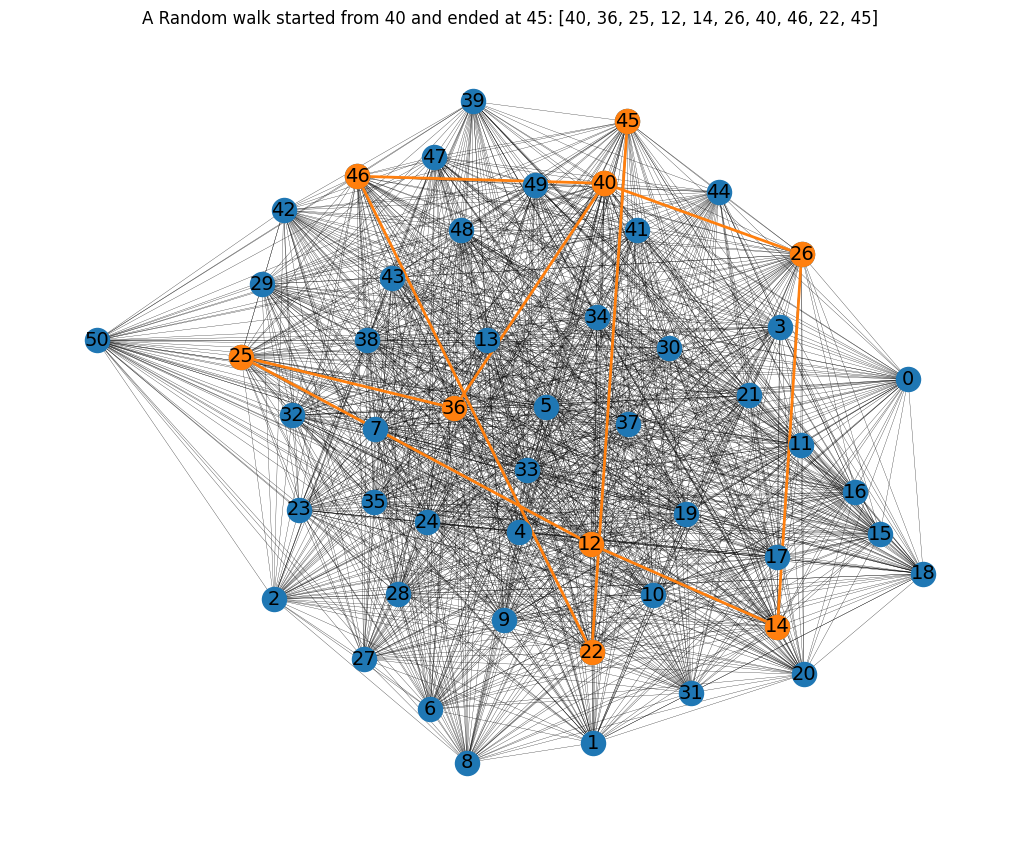

In [41]:
import networkx as nx  
import matplotlib.pyplot as plt  
import numpy as np  
import ast
from collections import Counter

# Extract the graphs
all_graphs = graph_data['all_graphs'].copy()

file_number = 2
walk_lenght = 80
for i in [file_number]:  
    for vector_size in [2]:  
        print(i, vector_size)  
        # BoW Labels graph  
        G_bow = all_graphs[(i, vector_size)].copy()  # Create a deep copy of the graph 
        walks = generate_random_walks(G_bow)  

        print(f"Generated {len(walks)} random walks.")

        pos = nx.spring_layout(G_bow)  

        # Decrease all edge weights by 1 for reducing the course
        for u, v, data in G_bow.edges(data=True):
            data['weight'] = max(0, data['weight'] - 1)  # Ensure weights don't go below 0

        # Draw the full graph with variable edge widths  
        fig = plt.figure(figsize=(10, 8))  
        nx.draw(G_bow, pos, with_labels=True, width=0.2, font_size=14, node_color='tab:blue')  
    
        # Highlight the nodes on the selected random walk  
        selected_node = 40  
        walk_nodes = walks[selected_node*walk_lenght]  
        print(walk_nodes)
        plt.title(f"A Random walk started from {walk_nodes[0]} and ended at {walk_nodes[-1]}: {walk_nodes}")  

        walk_edges = [(walk_nodes[i], walk_nodes[i+1]) for i in range(len(walk_nodes)-1)]  
        
        # Draw the nodes on the selected random walk  
        nx.draw_networkx_nodes(G_bow, pos, nodelist=walk_nodes, node_color='tab:orange', node_size=300)  

        # Draw the edges on the selected random walk  
        nx.draw_networkx_edges(G_bow, pos, edgelist=walk_edges, edge_color='tab:orange', width=2)  

        # # Save the figure
        fig.savefig(f"results/random-walk-{file_number}-node{selected_node}.png", dpi=100)  # Adjust dpi as needed
        # # plt.close()  # Close the plot if you are done with it


## Compare representation methods

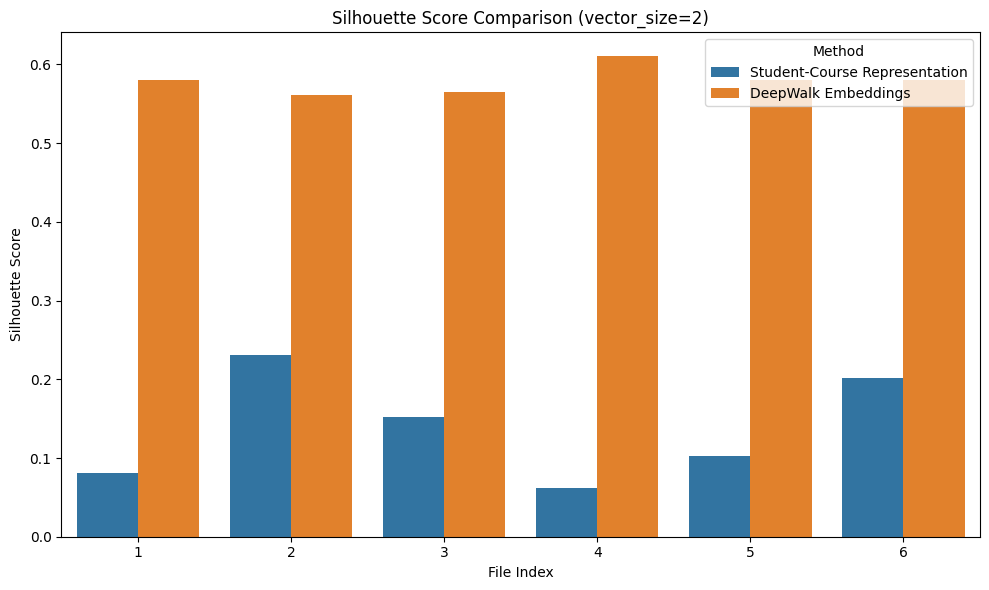

In [46]:
vector_size = 2  
filtered_df = df[df['vector_size'] == vector_size]  

# Filter to keep only the first occurrence of each file_index  
unique_filtered_df = filtered_df[['file_index', 'BoW.silhouette_score', 'embeddings.silhouette_score']].drop_duplicates(subset='file_index')  

df_melted_silhouette = unique_filtered_df.melt(id_vars=['file_index'],  
                                                 value_vars=['BoW.silhouette_score', 'embeddings.silhouette_score'],  
                                                 var_name='Method',  
                                                 value_name='Silhouette Score')  

df_melted_silhouette.loc[df_melted_silhouette['Method'] == 'BoW.silhouette_score', 'Method'] = 'Student-Course Representation'  
df_melted_silhouette.loc[df_melted_silhouette['Method'] == 'embeddings.silhouette_score', 'Method'] = 'DeepWalk Embeddings'  

plt.figure(figsize=(10, 6))   
sns.barplot(x='file_index', y='Silhouette Score', hue='Method', data=df_melted_silhouette)   
plt.title('Silhouette Score Comparison (vector_size=2)')   
plt.xlabel('File Index')  
plt.ylabel('Silhouette Score')  
plt.tight_layout()  
plt.savefig(f"results/silhouette_score_comparison_vector-size-{vector_size}.png")  
plt.show()

In [47]:
average_bow = df_melted_silhouette.groupby('Method')['Silhouette Score'].mean()['Student-Course Representation']  
average_deepwalk = df_melted_silhouette.groupby('Method')['Silhouette Score'].mean()['DeepWalk Embeddings']
mean_diff = average_deepwalk - average_bow  
print(mean_diff)

0.44136891707978027


In [48]:
file_number = 5
filepath = f"data/{file_number}.txt"  
result = process_and_cluster(filepath, vector_size=2)

Nodes: 100%|██████████| 52/52 [00:00<00:00, 53.48it/s]
c:\programs\anaconda3\envs\pth\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\programs\anaconda3\envs\pth\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [49]:
student_course_matrix, _ = read_class(filepath)
student_course_matrix.shape

(52, 32)

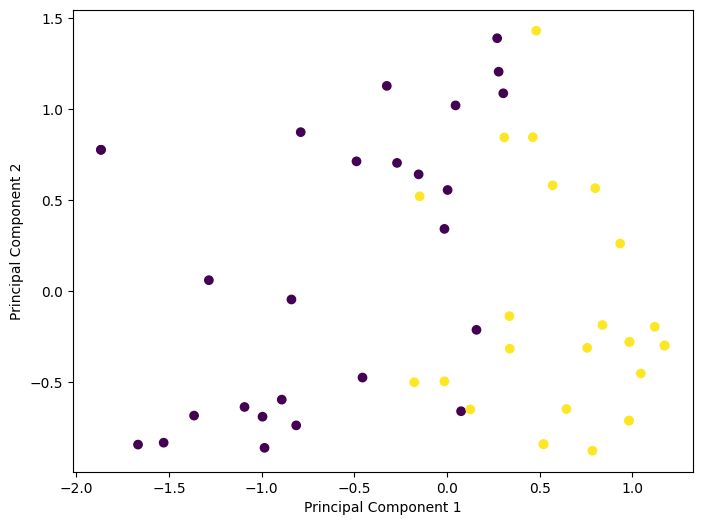

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Apply PCA
pca = PCA(n_components=2)
reduced_matrix = pca.fit_transform(student_course_matrix)
labels = result['BoW.labels']
# Step 2: Visualize the result
plt.figure(figsize=(8, 6))
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=labels, marker='o')

# plt.title('PCA of Student Course Matrix')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# plt.grid()
plt.savefig(f"results/PCA-BoW-{file_number}.png")
plt.show()


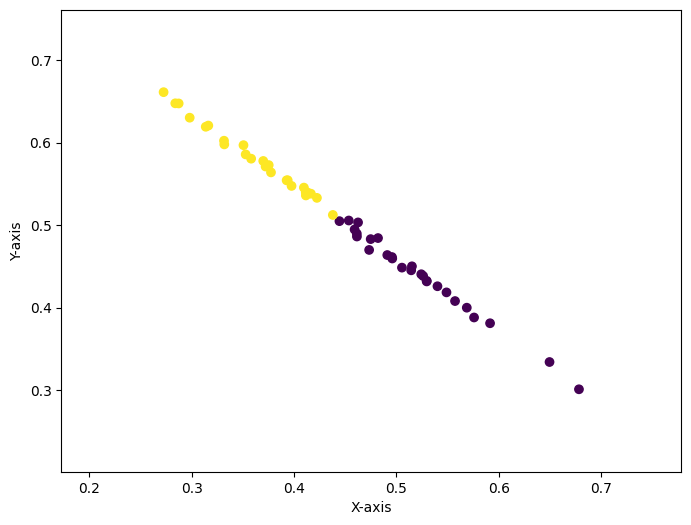

In [52]:
# from matplotlib.colors import ListedColormap
data = result['embeddings']
labels = result['embeddings.labels']
x = data[:, 0]  # x-coordinates
y = data[:, 1]  # y-coordinates

# Define a colormap and create a list of unique labels
unique_labels = np.unique(labels)

# Create a scatter plot with colors based on labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y, c=labels,  marker='o') #cmap=cmap,
# plt.title(f"Scatter Plot of {len(x)} Points")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim(min(x) - 0.1, max(x) + 0.1)
plt.ylim(min(y) - 0.1, max(y) + 0.1)
# plt.grid(True)
plt.savefig(f"results/DeepWalk-Two-Dim-Space-{file_number}.png")
plt.show()

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_scores(df, score_name, file_indices=None):
    # Validate score_name
    if score_name not in ['silhouette', 'balance']:
        raise ValueError("score_name must be either 'silhouette' or 'balance'")

    # Filter the dataframe based on the file_indices if provided
    if file_indices is not None:
        df = df[df['file_index'].isin(file_indices)]
    
    # Determine the corresponding column names based on the score name
    if score_name == 'silhouette':
        column_name_bow = "BoW.silhouette_score"
        column_name_embeddings = "embeddings.silhouette_score"
        title = "Silhouette Scores for Different Vector Sizes"
    elif score_name == 'balance':
        column_name_bow = "BoW.balance_score"
        column_name_embeddings = "embeddings.balance_score"
        title = "Balance Scores for Different Vector Sizes"

    # Plot the scores  
    fig = plt.figure(figsize=(6, 4))  
    sns.lineplot(x="vector_size", y=column_name_bow, data=df, 
                 label="Student-Course Representation", marker='o')  
    sns.lineplot(x="vector_size", y=column_name_embeddings, data=df, 
                 label="DeepWalk Embeddings", marker='s')  
    plt.title(title)  
    plt.xlabel("Vector Size")  
    plt.ylabel(f"{score_name.capitalize()} Score")  
    plt.legend()  
    plt.show()  

    # Create a descriptive filename
    if file_indices is not None:
        file_indices_str = "_".join(map(str, file_indices))
        score_png_file_name = f'results/{score_name}_score_file_indices_{file_indices_str}.png'
    else:
        score_png_file_name = f'results/{score_name}_score.png'
    
    fig.savefig(score_png_file_name)
    print(f"Figure saved as: {score_png_file_name}")


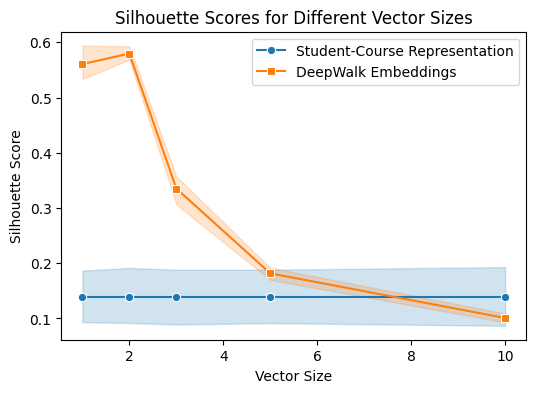

Figure saved as: results/silhouette_score.png
             BoW.silhouette_score  embeddings.silhouette_score
vector_size                                                   
1                         0.13835                     0.560622
2                         0.13835                     0.579719
3                         0.13835                     0.335159
5                         0.13835                     0.181647
10                        0.13835                     0.100768


In [54]:
import pandas as pd

# Read the Excel file
# df = pd.read_excel('results/df.xlsx')
plot_scores(df, 'silhouette')
# Group the data by 'vector_size' and calculate the mean of the scores  
average_scores = df.groupby('vector_size')[['BoW.silhouette_score', 'embeddings.silhouette_score']].mean()  

# Print the average scores  
print(average_scores) 

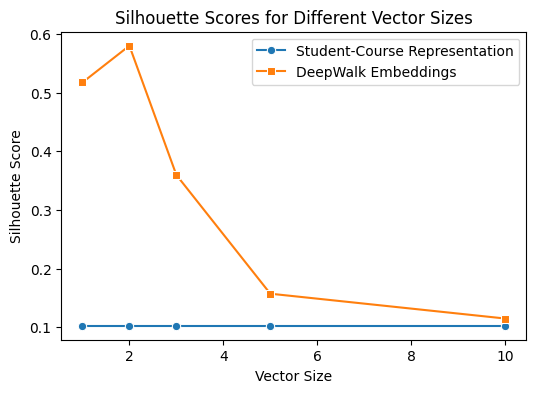

Figure saved as: results/silhouette_score_file_indices_5.png


In [55]:
plot_scores(df, 'silhouette', file_indices=[5])

Run various clustering methods

In [18]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift  
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score  
from gensim.models import Word2Vec  
import networkx as nx  
import ast  # Needed to safely evaluate a string that represents a list  

# load the previous computed embeddings
df = pd.read_excel('results/df.xlsx')

In [11]:
def cluster_students_and_evaluate(data):  
    results = {}  

    # KMeans  
    kmeans = KMeans(n_clusters=2, random_state=42).fit(data)  
    results['kmeans_labels'] = kmeans.labels_  
    results['kmeans_silhouette'] = silhouette_score(data, kmeans.labels_)  
    results['kmeans_davies_bouldin'] = davies_bouldin_score(data, kmeans.labels_)  
    results['kmeans_calinski_harabasz'] = calinski_harabasz_score(data, kmeans.labels_)  

    # DBSCAN  
    dbscan = DBSCAN(eps=0.5, min_samples=5).fit(data)  
    results['dbscan_labels'] = dbscan.labels_  
    if len(set(dbscan.labels_)) > 1:  
        results['dbscan_silhouette'] = silhouette_score(data, dbscan.labels_)  
        results['dbscan_davies_bouldin'] = davies_bouldin_score(data, dbscan.labels_)  
        results['dbscan_calinski_harabasz'] = calinski_harabasz_score(data, dbscan.labels_)  
    else:  
        results['dbscan_silhouette'] = float('nan')  
        results['dbscan_davies_bouldin'] = float('nan')  
        results['dbscan_calinski_harabasz'] = float('nan')  

    # Agglomerative Clustering  
    agglomerative = AgglomerativeClustering(n_clusters=2).fit(data)  
    results['agglomerative_labels'] = agglomerative.labels_  
    results['agglomerative_silhouette'] = silhouette_score(data, agglomerative.labels_)  
    results['agglomerative_davies_bouldin'] = davies_bouldin_score(data, agglomerative.labels_)  
    results['agglomerative_calinski_harabasz'] = calinski_harabasz_score(data, agglomerative.labels_)  

    # # Mean Shift  
    # meanshift = MeanShift().fit(data)  
    # results['meanshift_labels'] = meanshift.labels_  
    # results['meanshift_silhouette'] = silhouette_score(data, meanshift.labels_)  
    # results['meanshift_davies_bouldin'] = davies_bouldin_score(data, meanshift.labels_)  
    # results['meanshift_calinski_harabasz'] = calinski_harabasz_score(data, meanshift.labels_)  

    return results  

In [14]:
# Main Processing  

# Loop over file_index  
for file_index in range(1, 7):  # Adjust based on actual file indices  
    print(f"Processing file index: {file_index}")  

    # Get the embeddings for vector_size=2 for the current file_index  
    embeddings_row = df[(df['file_index'] == file_index) & (df['vector_size'] == 2)]  
    if embeddings_row.empty:  
        print(f"No embeddings found for file_index={file_index} and vector_size=2")  
        continue  

    # Extract the embeddings  
    embeddings = embeddings_row['embeddings'].values[0]  # Assuming it's stored as an array-like object  
    file_path = f"data/{file_index}.txt"  # Update the path based on your data files  
    print(type(embeddings[0]))
    # Process data and get student-course matrix  
    student_course_matrix, courses = read_class(file_path)  

    # Cluster and evaluate raw data and embeddings  
    results_student_course = cluster_students_and_evaluate(student_course_matrix)  
    results_embeddings = cluster_students_and_evaluate(embeddings)  

    # Store results in a DataFrame  
    df_results = pd.DataFrame([results_student_course, results_embeddings],  
                                index=['Student-Course Representation', 'DeepWalk Embeddings'])  

    # Save and visualize results  
    print(df_results)  

    # Visualizing silhouette scores  
    silhouette_metrics = df_results[['kmeans_silhouette', 'dbscan_silhouette', 'agglomerative_silhouette']]  
    silhouette_metrics.plot.bar()  
    plt.title(f'Silhouette Score Comparison for file_index={file_index}')  
    plt.ylabel('Silhouette Score')  
    plt.tight_layout()  
    plt.savefig(f'results/silhouette_score_comparison_file_{file_index}.png')  
    plt.show()  

Processing file index: 1
<class 'str'>


c:\programs\anaconda3\envs\pth\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


ValueError: could not convert string to float: '[[ 0.04911656  0.6120962 ]\n [ 0.11755195  0.59943527]\n [ 0.12499458  0.6057743 ]\n [ 0.08249693  0.60275507]\n [ 0.18191087  0.59427065]\n [ 0.10322481  0.60424423]\n [ 0.0543814   0.6059158 ]\n [-0.03739472  0.6298312 ]\n [ 0.0108599   0.61686325]\n [ 0.13606416  0.59961313]\n [ 0.03792208  0.6086419 ]\n [ 0.2303289   0.5839136 ]\n [ 0.00777555  0.6143051 ]\n [ 0.13404207  0.5989881 ]\n [ 0.19052018  0.59099543]\n [ 0.1925518   0.5913301 ]\n [-0.02375261  0.6209659 ]\n [-0.12964672  0.63513917]\n [-0.0892271   0.6300044 ]\n [ 0.16471276  0.5968582 ]\n [ 0.29378033  0.57830846]\n [ 0.16080153  0.5973512 ]\n [ 0.19118208  0.5959327 ]\n [ 0.02765874  0.61519504]\n [ 0.2998442   0.58033484]\n [ 0.1168215   0.6027372 ]\n [ 0.04263902  0.61538386]\n [ 0.00541486  0.6166648 ]\n [ 0.2258229   0.58926797]\n [ 0.06755773  0.60899365]\n [-0.03680433  0.6200216 ]\n [ 0.30165434  0.5814887 ]\n [ 0.35132524  0.5700203 ]\n [ 0.26994023  0.57764924]\n [-0.15462053  0.6431005 ]\n [-0.15920176  0.6429409 ]\n [ 0.05862739  0.61028683]\n [ 0.08230419  0.61306286]\n [ 0.01352736  0.6160481 ]\n [ 0.12707259  0.59741735]\n [-0.03606954  0.6255903 ]\n [ 0.0596351   0.6142934 ]\n [-0.09207605  0.63291097]\n [ 0.08648055  0.60055965]\n [ 0.04624506  0.60701644]\n [ 0.19186723  0.59132725]\n [-0.03744788  0.6271353 ]\n [ 0.2505466   0.57928544]\n [ 0.31722778  0.5721836 ]\n [ 0.08386788  0.60971075]\n [-0.12434628  0.63721764]\n [ 0.03854569  0.6097379 ]\n [ 0.1311993   0.59914213]\n [ 0.01245003  0.6119299 ]\n [ 0.25859594  0.58548194]\n [-0.14424734  0.6354597 ]\n [ 0.03870605  0.61064374]\n [ 0.25214922  0.5824758 ]\n [ 0.08226934  0.6073947 ]\n [ 0.2539963   0.58139485]\n [-0.03078196  0.62428737]\n [-0.07150891  0.6285389 ]\n [ 0.06349341  0.60870355]\n [ 0.30927226  0.5708306 ]\n [ 0.00681646  0.619472  ]\n [ 0.07714476  0.61158633]\n [-0.00799552  0.61173433]\n [-0.03177518  0.6252494 ]\n [ 0.21071246  0.5893536 ]\n [ 0.03965502  0.6138256 ]\n [ 0.02336891  0.6171154 ]\n [-0.02419764  0.62010497]\n [ 0.13013296  0.6063297 ]\n [ 0.16616887  0.5916269 ]]'

In [19]:
        # Extract the embeddings (assuming it's a list of lists represented as a string)  
        embeddings_str = embeddings_row['embeddings'].values[0]  # Get the string representation  

        # Clean the string and convert it to a list of lists  
        embeddings_cleaned = embeddings_str.replace('\n', '').replace(' ', '')  # Remove newline and excess whitespace  

        # Convert cleaned string to a 2D list using ast.literal_eval  
        embeddings_list = ast.literal_eval(embeddings_cleaned)  

        # Convert the list of lists to a numpy array  
        embeddings_array = np.array(embeddings_list)  

        # Confirm the shape and type (optional)  
        print("Shape of embeddings array:", embeddings_array.shape)  
        print("Type of embeddings array:", embeddings_array.dtype)  

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)

In [15]:
embeddings

'[[ 0.04911656  0.6120962 ]\n [ 0.11755195  0.59943527]\n [ 0.12499458  0.6057743 ]\n [ 0.08249693  0.60275507]\n [ 0.18191087  0.59427065]\n [ 0.10322481  0.60424423]\n [ 0.0543814   0.6059158 ]\n [-0.03739472  0.6298312 ]\n [ 0.0108599   0.61686325]\n [ 0.13606416  0.59961313]\n [ 0.03792208  0.6086419 ]\n [ 0.2303289   0.5839136 ]\n [ 0.00777555  0.6143051 ]\n [ 0.13404207  0.5989881 ]\n [ 0.19052018  0.59099543]\n [ 0.1925518   0.5913301 ]\n [-0.02375261  0.6209659 ]\n [-0.12964672  0.63513917]\n [-0.0892271   0.6300044 ]\n [ 0.16471276  0.5968582 ]\n [ 0.29378033  0.57830846]\n [ 0.16080153  0.5973512 ]\n [ 0.19118208  0.5959327 ]\n [ 0.02765874  0.61519504]\n [ 0.2998442   0.58033484]\n [ 0.1168215   0.6027372 ]\n [ 0.04263902  0.61538386]\n [ 0.00541486  0.6166648 ]\n [ 0.2258229   0.58926797]\n [ 0.06755773  0.60899365]\n [-0.03680433  0.6200216 ]\n [ 0.30165434  0.5814887 ]\n [ 0.35132524  0.5700203 ]\n [ 0.26994023  0.57764924]\n [-0.15462053  0.6431005 ]\n [-0.15920176  0.64